In [1]:
import sys
sys.path.append("../")
from datasets import generate_samples_from_3d_torus, generate_samples_from_3d_sphere, generate_mog_3d

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
from IPython.display import display, clear_output
import pandas as pd
# import seaborn as sns
import math
import torch
import numpy as np
import random
from typing import Tuple, Optional, List
import torch.distributions as D

/Users/marcobertolini/Projects/symmetry-induced-score-matching/sism/notebooks/../datasets.py:110: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/aten/src/ATen/native/TensorShape.cpp:3701.)
  rotated_mean = (R @ mean.T).T


In [105]:
def generate_mog_4d(num_samples, random_seed: int = 42):
    torch.manual_seed(random_seed)
    device = torch.device("cpu")

    ngauss = 5
    means = torch.randn((ngauss, 4)) * 5.
    vars = torch.rand(ngauss, 4, device=device) * 1.0
    pi = torch.randn(ngauss, device=device).softmax(dim=0)
    mix = D.Categorical(pi)
    comp = D.Independent(D.Normal(means, vars), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    selected_samples = gmm.sample((num_samples,))
    return selected_samples, gmm

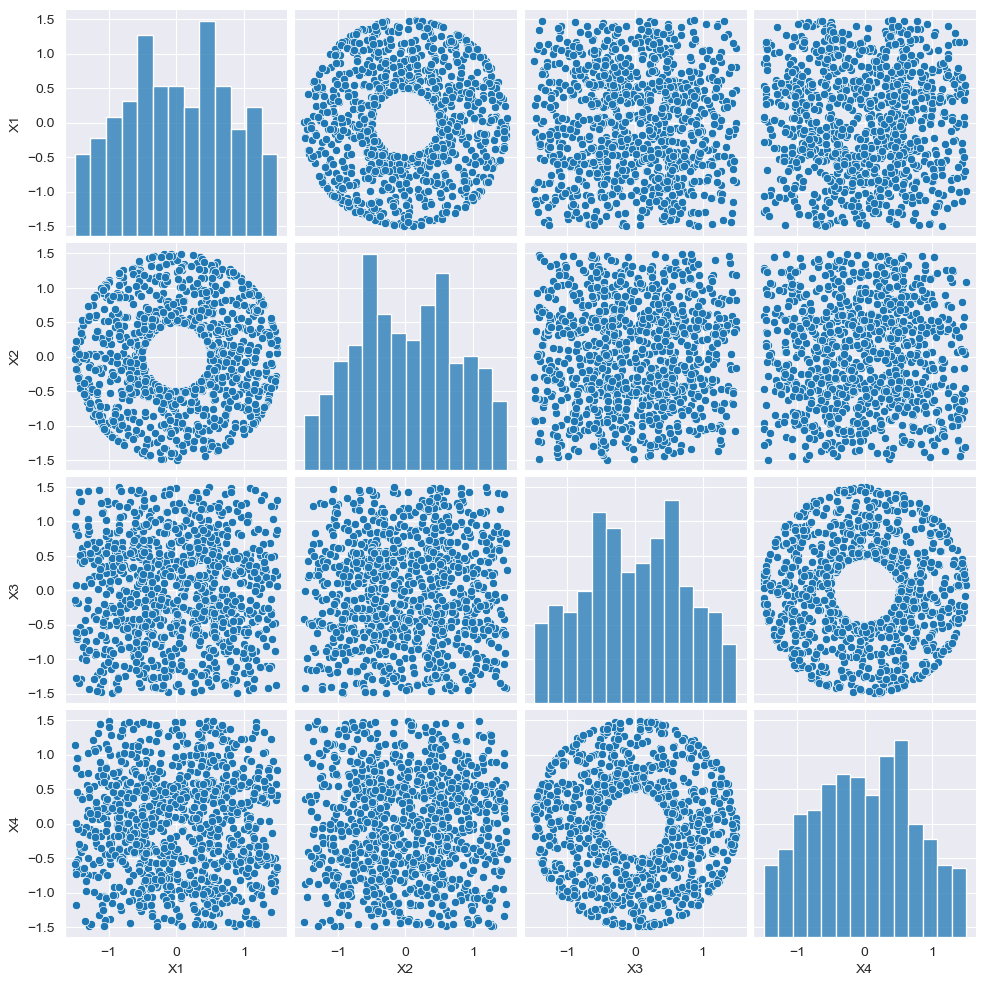

In [106]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate 4D hypertorus samples
def generate_hypertorus_samples(nsamples, R=1.0, r=0.5, random_seed=42):
    np.random.seed(random_seed)
    theta1 = np.random.uniform(0, 2 * np.pi, nsamples)
    theta2 = np.random.uniform(0, 2 * np.pi, nsamples)
    theta3 = np.random.uniform(0, 2 * np.pi, nsamples)
    theta4 = np.random.uniform(0, 2 * np.pi, nsamples)

    x1 = (R + r * np.cos(theta2)) * np.cos(theta1)
    x2 = (R + r * np.cos(theta2)) * np.sin(theta1)
    x3 = (R + r * np.cos(theta4)) * np.cos(theta3)
    x4 = (R + r * np.cos(theta4)) * np.sin(theta3)

    hypertorus_samples = np.stack([x1, x2, x3, x4], axis=1)
    return hypertorus_samples

# Generate samples
hypertorus_samples = generate_hypertorus_samples(1000, R=1.0, r=0.5)

# Convert to DataFrame for visualization
df = pd.DataFrame(hypertorus_samples, columns=['X1', 'X2', 'X3', 'X4'])

# Create pairwise scatter plot matrix
sns.pairplot(df)
plt.show()

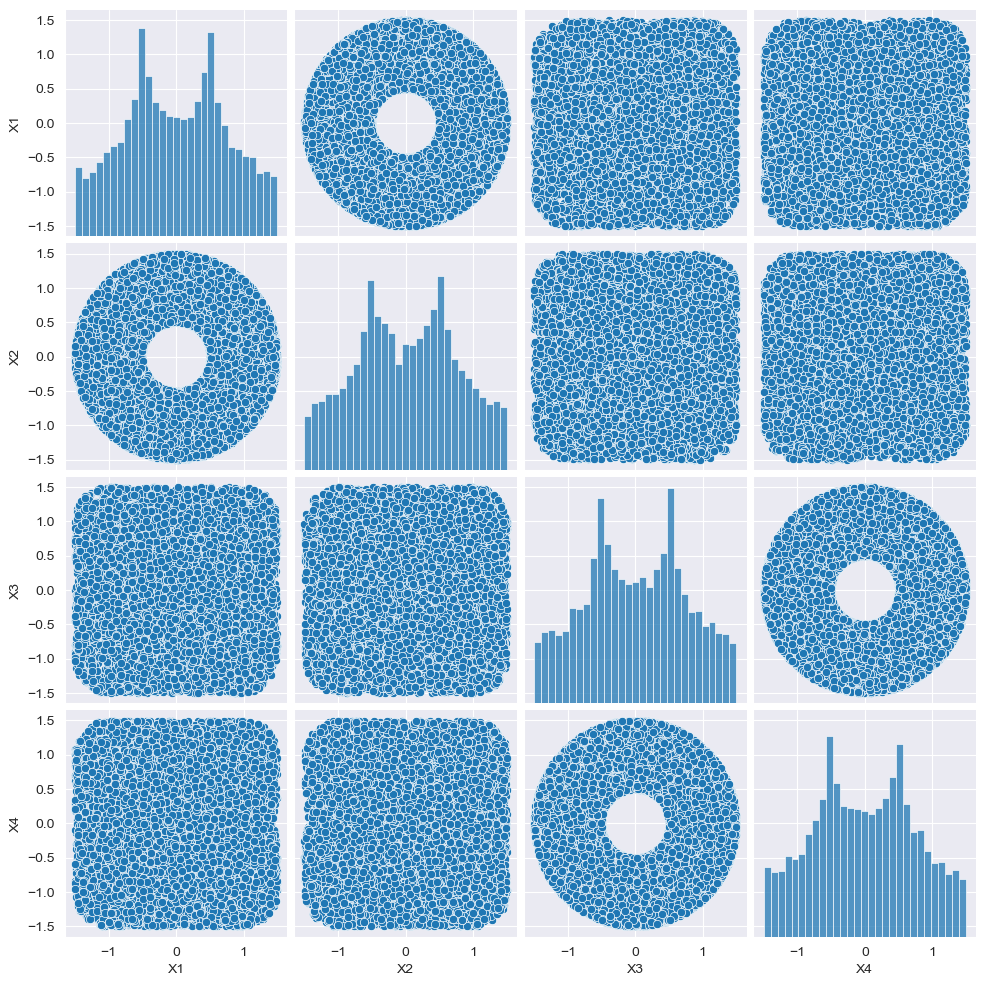

In [107]:
import numpy as np

def generate_parametric_tiger_hypertorus_samples(nsamples, a=1.0, b=1.0, r=0.5, random_seed=42):
    np.random.seed(random_seed)
    # Generate samples uniformly within the range [0, 2*pi] for each angle
    theta1 = np.random.uniform(0, 2 * np.pi, nsamples)
    theta2 = np.random.uniform(0, 2 * np.pi, nsamples)
    theta3 = np.random.uniform(0, 2 * np.pi, nsamples)

    # Parametric equations for the 4D hypertorus
    x = a * np.cos(theta1) + r * np.cos(theta1) * np.cos(theta3)
    y = a * np.sin(theta1) + r * np.sin(theta1) * np.cos(theta3)
    z = b * np.cos(theta2) + r * np.cos(theta2) * np.sin(theta3)
    w = b * np.sin(theta2) + r * np.sin(theta2) * np.sin(theta3)

    # Stack the coordinates
    hypertorus_samples = np.stack([x, y, z, w], axis=1)
    hypertorus_samples_tensor = torch.tensor(hypertorus_samples, dtype=torch.float32)

    return hypertorus_samples_tensor

# Example usage
tiger_samples = generate_parametric_tiger_hypertorus_samples(10000, a=1.0, b=1.0, r=0.5)

# Convert to DataFrame for visualization
df = pd.DataFrame(tiger_samples, columns=['X1', 'X2', 'X3', 'X4'])

# Create pairwise scatter plot matrix
sns.pairplot(df)
plt.show()

In [108]:
import torch
import torch.nn as nn
figsize = (6, 6)

In [109]:
class SO4Prior:
    def __init__(self, std_r=1, std_theta=1):
        self.std_r = std_r
        self.std_theta = std_theta
        self.log_r_d = torch.distributions.Normal(0, 1)
        self.theta_d = torch.distributions.Normal(0, 1)
        
    def sample(self, n):
        r = torch.exp(self.log_r_d.sample((n,)) * self.std_r)
        theta = self.theta_d.sample((n,)) * self.std_theta
        phi2 = self.theta_d.sample((n,)) * self.std_theta
        phi3 = self.theta_d.sample((n,)) * self.std_theta
        return torch.stack([r, theta, phi2, phi3], dim=-1)

In [110]:
x = torch.randn(1, 3)

In [111]:
I = torch.eye(4).float().unsqueeze(0)
Ax = torch.tensor([[0, 0, 0],
                   [0, 0, -1],
                   [0, 1, 0]]).float().unsqueeze(0)
Ay = torch.tensor([[0, 0, 1],
                   [0, 0, 0],
                   [-1, 0, 0]]).float().unsqueeze(0)
Az = torch.tensor([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 0]]).float().unsqueeze(0)

A34 = torch.tensor([[0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, -1],
                   [0, 0, 1, 0]]).float().unsqueeze(0)

A24 = torch.tensor([[0, 0, 0, 0],
                   [0, 0, 0, -1],
                   [0, 0, 0, 0],
                   [0, 1, 0, 0]]).float().unsqueeze(0)

A23 = torch.tensor([[0, 0, 0, 0],
                   [0, 0, -1, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 0]]).float().unsqueeze(0)

A14 = torch.tensor([[0, 0, 0, -1],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [1, 0, 0, 0]]).float().unsqueeze(0)

A13 = torch.tensor([[0, 0, -1, 0],
                   [0, 0, 0, 0],
                   [1, 0, 0, 0],
                   [0, 0, 0, 0]]).float().unsqueeze(0)

A12 = torch.tensor([[0, -1, 0, 0],
                   [1, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]]).float().unsqueeze(0)



ex = torch.tensor([1,0,0]).float().unsqueeze(0)
ey = torch.tensor([0,1,0]).float().unsqueeze(0)
ez = torch.tensor([0,0,1]).float().unsqueeze(0)

In [112]:
Ax

tensor([[[ 0.,  0.,  0.],
         [ 0.,  0., -1.],
         [ 0.,  1.,  0.]]])

In [113]:
def vector_to_skew_matrix(x, Ax, Ay, Az):
        """_summary_
        Computes the skew-form of a vector.
        I.e. transforming a vector into a lie algebra element of SO(3) by left multiplication with the basis matrices.
        """
        skew = (x[:, 0].unsqueeze(-1).unsqueeze(-1) * Ax + x[:, 1].unsqueeze(-1).unsqueeze(-1) * Ay + x[:, 2].unsqueeze(1).unsqueeze(-1) * Az)
        return skew


def vector_to_skew_matrix4d(x, A12, A13, A14, A23, A24, A34):
    """_summary_
    Computes the skew-form of a vector.
    I.e. transforming a vector into a lie algebra element of SO(3) by left multiplication with the basis matrices.
    """
    skew = (x[:, 0].unsqueeze(-1).unsqueeze(-1) * A12 + x[:, 1].unsqueeze(-1).unsqueeze(-1) * A13 + x[:, 2].unsqueeze(-1).unsqueeze(-1) * A14 +
            x[:, 3].unsqueeze(-1).unsqueeze(-1) * A23 + x[:, 4].unsqueeze(-1).unsqueeze(-1) * A24 + x[:, 5].unsqueeze(-1).unsqueeze(-1) * A34)
    return skew

In [114]:
def rodrigues_formula_skew(S: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    """_summary_
    Computes the exponential map of a skew-symmetric matrix using the Rodrigues formula.
    """
    assert S.shape[-1] == 3
    assert S.shape[-2] == 3
    O = I + torch.sin(theta) * S + (1 - torch.cos(theta)) * S.matmul(S)
    return O

In [115]:
import numpy as np
from scipy.linalg import expm

Aphi3 = torch.tensor([[0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, -1],
                   [0, 0, 1, 0]]).float().unsqueeze(0)


Aphi2 = torch.tensor([[0, 0, 0, 0],
                   [0, 0, torch.sin(torch.tensor(30)), torch.cos(torch.tensor(30))],
                   [0, -torch.sin(torch.tensor(30)), 0, 0],
                   [0, -torch.cos(torch.tensor(30)), 0, 0]]).float().unsqueeze(0)
torch.matrix_exp(Aphi2)

tensor([[[ 1.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5403, -0.8314,  0.1298],
         [ 0.0000,  0.8314,  0.5512,  0.0701],
         [ 0.0000, -0.1298,  0.0701,  0.9891]]])

In [116]:
def to_cartesian(input):
    if input.dim() == 1:
        input = input.unsqueeze(dim=0)
    r, theta, phi2, phi3 = input.chunk(4, dim=1)
    x4 = r * torch.sin(theta) * torch.sin(phi2) * torch.sin(phi3)
    x3 = r * torch.sin(theta) * torch.sin(phi2) * torch.cos(phi3)
    x2 = r * torch.sin(theta) * torch.cos(phi2)
    x1 = r * torch.cos(theta)
    return torch.concat([x1, x2, x3, x4], dim=1)

def to_hyperspherical(input):
    if input.dim() == 1:
        input = input.unsqueeze(dim=0)
    x1, x2, x3, x4 = input.chunk(4, dim=1)
    r = torch.sqrt(x1**2 + x2**2 + x3**2 + x4**2)
    theta = torch.atan2((x2**2 + x3**2 + x4**2)**0.5, x1)
    phi2 = torch.atan2((x3**2 + x4**2)**0.5, x2)
    phi3 = torch.atan2(x4, x3)
    return torch.concat([r, theta, phi2, phi3], dim=1)

In [117]:
def forward_noising_vp(input: torch.Tensor,
                       s: torch.Tensor,
                       m: torch.Tensor,
                       sqrt: bool = False,
                       ) -> Tuple[torch.Tensor, torch.Tensor]:
    
    if s.ndim == 1:
        s = s.unsqueeze(1)
    if m.ndim == 1:
        m = m.unsqueeze(1)
    
    r, theta, phi2, phi3 = to_hyperspherical(input).chunk(4, dim=1)
    r_n, theta_n, phi2_n, phi3_n = torch.randn_like(r), torch.randn_like(theta), torch.randn_like(phi2), torch.randn_like(phi3)
    if sqrt:
        m = m.sqrt()
    rt = m * r.log() + s * r_n
    tt = m * theta + s * theta_n
    p2t = m * phi2 + s * phi2_n
    p3t = m * phi3 + s * phi3_n
    
    input = torch.concat([rt.exp(), tt, p2t, p3t], dim=1)
    xt = to_cartesian(input)
    l = torch.concat([r_n, theta_n, phi2_n, phi3_n], dim=1)
    return xt, l

In [118]:
T = 100
def get_diffusion_coefficients(T, kind="linear-time", alpha_clip_min=0.001):
    if kind == "linear-time":
        t = np.linspace(1e-3, 1.0, T + 2)
        alphas_cumprod = 1.0 - t
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        betas = 1 - alphas
        betas = np.clip(betas, 0.0, 1.0 - alpha_clip_min)
        betas = torch.from_numpy(betas).float().squeeze()
    elif kind == "cosine":
        s = 0.008
        steps = T + 2
        x = torch.linspace(0, T, steps)
        alphas_cumprod = (
            torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5)
            ** 2
        )
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        alphas = alphas.clip(min=alpha_clip_min)
        betas = 1 - alphas
        betas = torch.clip(betas, 0.0, 1.0 - alpha_clip_min).float()
    elif kind == "ddpm":
        betas = torch.linspace(0.1 / T, 20 / T, T + 1)
    return betas

In [119]:
T = 100
betas = get_diffusion_coefficients(T, kind="cosine")

In [120]:
alpha = 1.0 - betas
mean_coeff = alpha.cumprod(dim=0)
std_coeff = (1.0 - mean_coeff).sqrt()

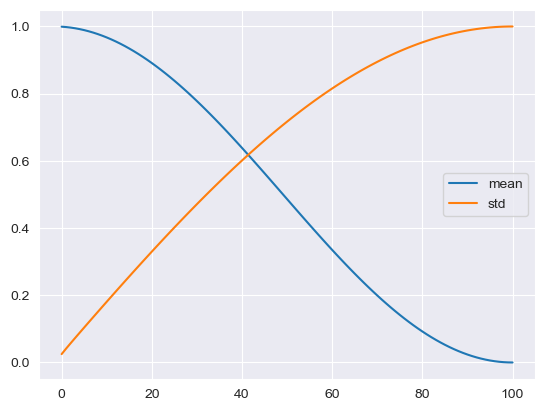

In [121]:
plt.plot(range(T+1), mean_coeff, label="mean")
plt.plot(range(T+1), std_coeff, label="std")
plt.legend()
plt.show()

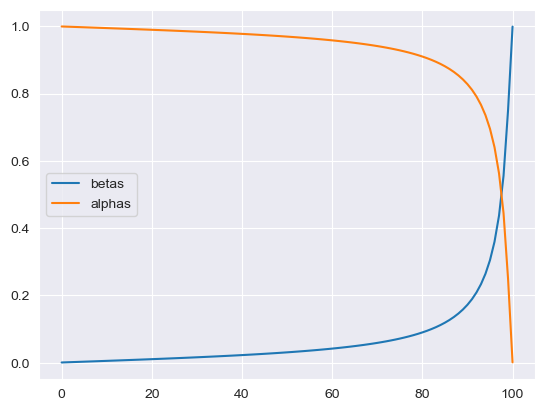

In [122]:
plt.plot(range(T+1), betas, label="betas")
plt.plot(range(T+1), alpha, label="alphas")
plt.legend()
plt.show()

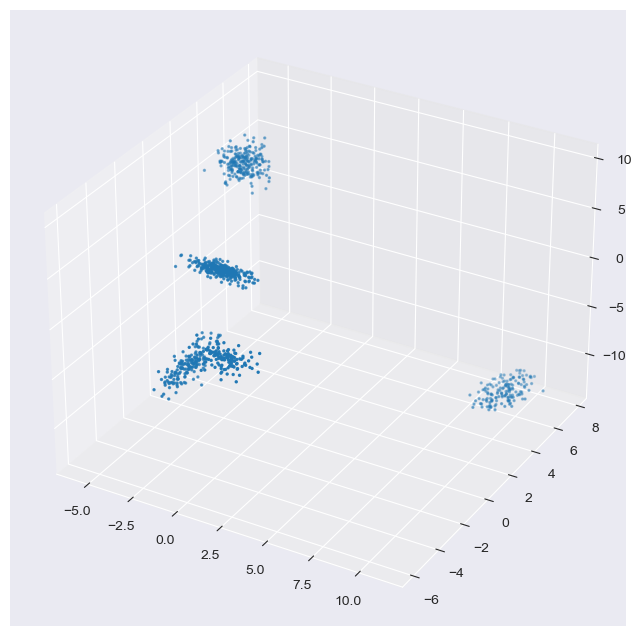

In [145]:
mog = True
torus = False
tiger = False

if mog:
    dataset, gmm = generate_mog_4d(1000)
    dataset = dataset - dataset.mean(0,keepdim=True)
elif tiger:
    dataset = generate_parametric_tiger_hypertorus_samples(1000, a=1.0, b=1.0, r=0.5)
    dataset = dataset - dataset.mean(0, keepdim=True)
else:
    dataset = generate_samples_from_3d_torus(nsamples=10_000, R=3., r=1.)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 3], s=2)

device = torch.device("cpu")
if isinstance(dataset, np.ndarray):
    x = torch.from_numpy(dataset).float()
else:
    x = dataset.clone()
bs = 128
ids = np.arange(len(dataset))
torch_dataset = x.clone().to(device)
if torus:
    ax.view_init(30, 26)
    ax.set_zlim(-3, 3)
plt.show()

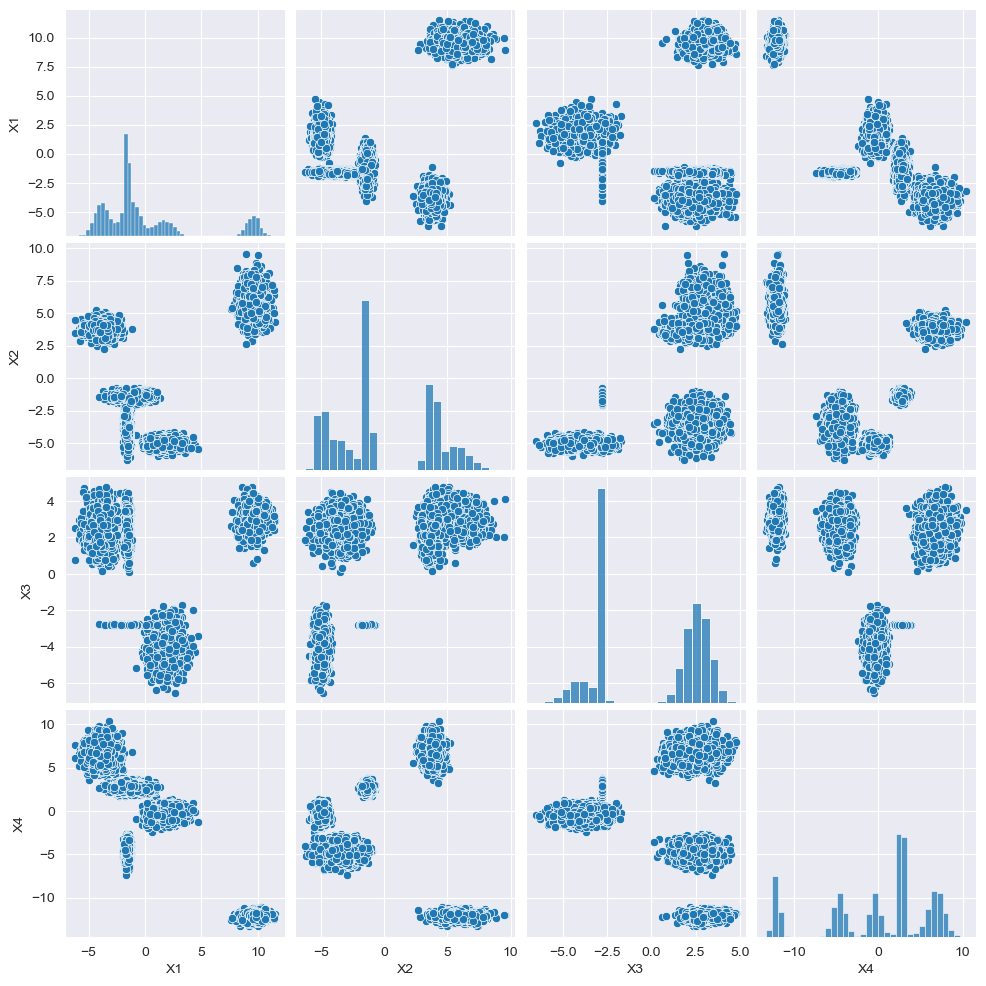

In [124]:
import seaborn as sns
df = pd.DataFrame(torch_dataset, columns=['X1', 'X2', 'X3', 'X4'])

# Create pairwise scatter plot matrix
sns.pairplot(df)
plt.show()

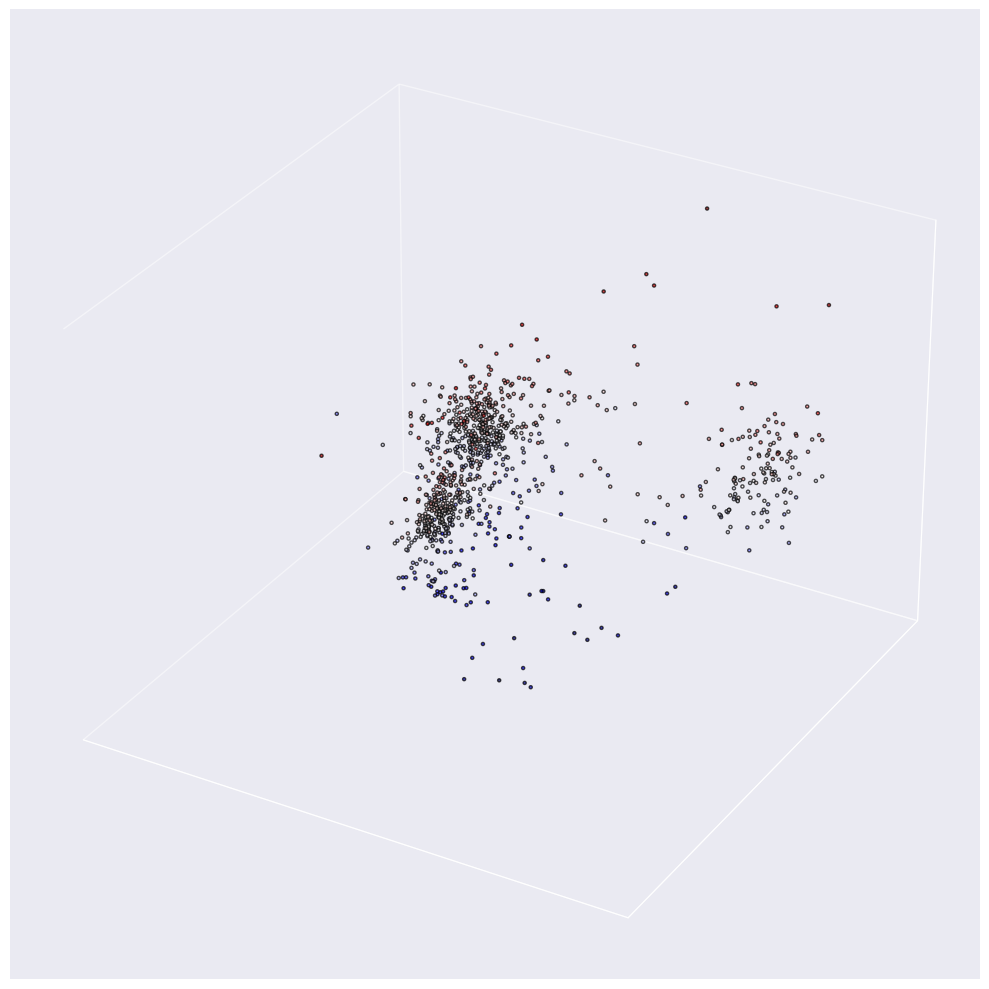

In [125]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Initialize plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Color map based on z values for depth effect
clean_array = xsampled_np[~np.isnan(xsampled_np).any(axis=1)]

z_vals = clean_array[:, 2]
colors = cm.seismic((z_vals - z_vals.min()) / (z_vals.max() - z_vals.min()))

# Scatter plot with color gradient and size adjustments
ax.scatter(clean_array[:, 0], clean_array[:, 1], clean_array[:, 2], c=colors, s=5, alpha=0.7, edgecolor='k')

# Device for PyTorch operations (set to CPU for this example)
device = torch.device("cpu")

if torus:
    ax.view_init(35, 45)  
    ax.set_zlim(-3, 3)   

# Hide panes and axes
ax.xaxis.pane.fill = False  # Remove x-axis pane
ax.yaxis.pane.fill = False  # Remove y-axis pane
ax.zaxis.pane.fill = False  # Remove z-axis pane

ax.xaxis.pane.set_edgecolor((1, 1, 1, 0))  # Make the edge transparent
ax.yaxis.pane.set_edgecolor((1, 1, 1, 0))
ax.zaxis.pane.set_edgecolor((1, 1, 1, 0))
                    
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Finalize and show the plot
plt.tight_layout()
plt.savefig('torus_distributions_gen.png')
plt.show()


  0%|          | 0/1000 [00:00<?, ?epoch/s]

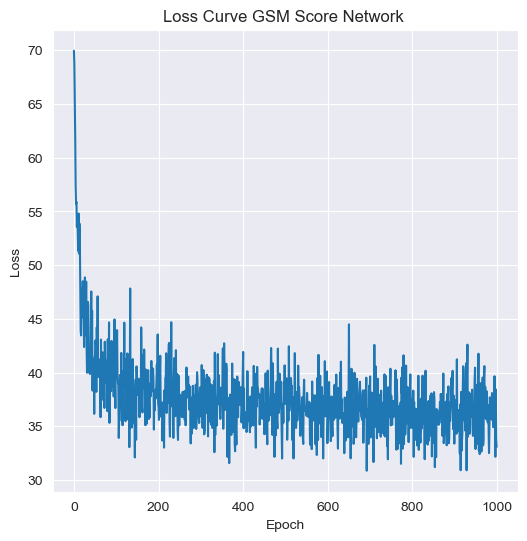

In [126]:
in_dim = 4
hidden_dim = 128
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(),
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(),
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            xt, target = forward_noising_vp(input=xin, m=signal, s=std, sqrt=True)
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve GSM Score Network ")
plt.show()

In [127]:
print(I)

prior = SO4Prior(std_r=1., std_theta=1.)

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])


  0%|          | 0/100 [00:00<?, ?it/s]

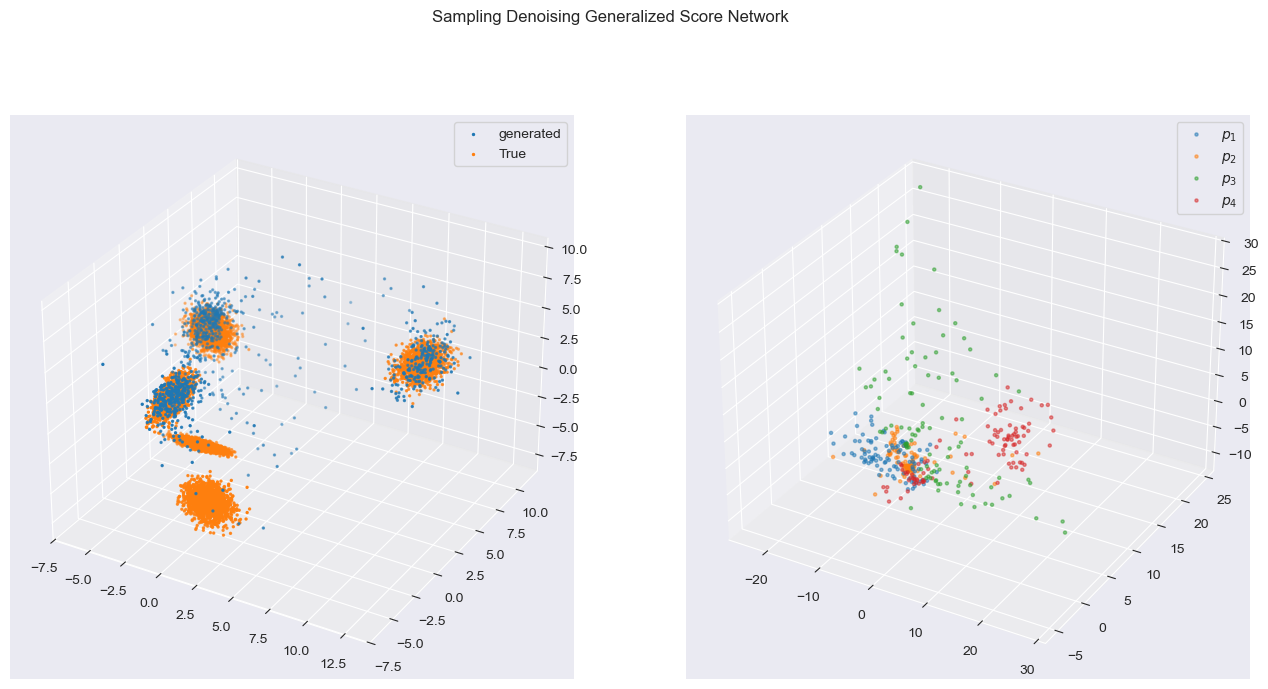

In [128]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi2_dynamic = True
phi3_dynamic = True

assert (sum((r_dynamic, theta_dynamic, phi2_dynamic, phi3_dynamic)) > 0)

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):  
        t_ = torch.tensor([t] * num_samples)
        
        beta = betas[t_].unsqueeze(-1)
        temb = (t_ / T).unsqueeze(-1)
        score = score_net(torch.concat([xsampled, temb], dim=-1))
        
        r, theta, phi2, phi3 = to_hyperspherical(xsampled).chunk(4, dim=1)
        
        # radius: drift and score
        d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
        A_phi3 = torch.concat([
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.ones_like(phi3),
        ], dim=-1)
        A_phi2 = torch.concat([
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.cos(phi3),
            torch.sin(phi3),
            torch.zeros_like(phi3),
        ], dim=-1)

        A_theta = torch.concat([
            torch.cos(phi2),
            torch.cos(phi3) * torch.sin(phi2),
            torch.sin(phi3) * torch.sin(phi2),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
        ], dim=-1)
            
        A_phi2 = vector_to_skew_matrix4d(A_phi2, A12, A13, A14, A23, A24, A34)
        A_phi3 = vector_to_skew_matrix4d(A_phi3, A12, A13, A14, A23, A24, A34)
        A_theta = vector_to_skew_matrix4d(A_theta, A12, A13, A14, A23, A24, A34)
        # theta: drift and score
        d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        # phi: drift and score
        d_phi2 =(0.5 * phi2 + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Aphi2, xsampled))
        d_phi3 =(0.5 * phi3 + score[:, 3].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Aphi3, xsampled))

        noise = torch.randn_like(score)
        nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
        n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        n_phi2 = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Aphi2, xsampled))
        n_phi3 = noise[:, 3].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Aphi3, xsampled))
                
        if r_dynamic:
            x_update = xsampled + beta * d_r
        else:
            x_update = xsampled
            
        if theta_dynamic:
            x_update = x_update + beta * d_theta
                            
        if phi2_dynamic:
            x_update = x_update + beta * d_phi2
        if phi3_dynamic:
            x_update = x_update + beta * d_phi3
        if stochastic:
            # noise term + casimir invariant terms + divergence term
            if r_dynamic:
                x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled  # + 4.0 * beta * xsampled
            if theta_dynamic:
                tmp = xsampled.clone()
                z = (tmp[:, -1]).clone()
                tmp[:, -1] = 0.0
                xysq = tmp.pow(2).sum(-1).sqrt()
                coeff = z / xysq.clamp_min(1e-2)
                # coeff1 = theta.cos() / theta.sin()
                div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
                #div0_x = xsampled[:, 0] * z.pow(2) / xysq.pow(2)
                #div0_y = xsampled[:, 1] * z.pow(2) / xysq.pow(2)
                #div0_z = -z
                #div0 = torch.stack([div0_x, div0_y, div0_z], dim=-1)
                #print("coeff: ", coeff, coeff1)
                #print("Atheta: ", A_theta)
                #print("xsampled: ", xsampled)
                #print("div: ", div)
                #print("div1: ", div0)
                #print()
                #print("----------------" * 20)
                #print()
                A_theta_casimir = A_theta @ A_theta
                x_update = x_update + beta.sqrt() * n_theta  + 0.5 * beta  * torch.einsum('bij,bj->bi', A_theta_casimir, xsampled) + beta * div
            if phi2_dynamic:
                A_phi2_casimir = A_phi2 @ A_phi2

                x_update = x_update + beta.sqrt() * n_phi2  + 0.5 * beta * torch.einsum('bij,bj->bi', A_phi2_casimir, xsampled) + 0.0
                # print(x_update.norm(p=2, dim=-1))
            if phi3_dynamic:
                tmp = xsampled.clone()
                tmp[:, 0] = 0.0
                tmp[:, 1] = 0.0
                x_update = x_update + beta.sqrt() * n_phi3  - 0.5 * beta * tmp + 0.0
        # if stochastic:
        #     # noise term + casimir invariant terms + divergence term
        #     if r_dynamic:
        #         x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled # + 3.0 * beta * xsampled
        #     if theta_dynamic:
        #         tmp = xsampled.clone()
        #         z = (tmp[:, -1]).clone()
        #         tmp[:, -1] = 0.0
        #         xysq = tmp.pow(2).sum(-1).sqrt()
        #         coeff = z / xysq.clamp_min(1e-2)
        #         # coeff1 = theta.cos() / theta.sin()
        #         div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        #         #div0_x = xsampled[:, 0] * z.pow(2) / xysq.pow(2)
        #         #div0_y = xsampled[:, 1] * z.pow(2) / xysq.pow(2)
        #         #div0_z = -z
        #         #div0 = torch.stack([div0_x, div0_y, div0_z], dim=-1)
        #         #print("coeff: ", coeff, coeff1)
        #         #print("Atheta: ", A_theta)
        #         #print("xsampled: ", xsampled)
        #         #print("div: ", div)
        #         #print("div1: ", div0)
        #         #print()
        #         #print("----------------" * 20)
        #         #print()
        #         x_update = x_update + beta.sqrt() * n_theta  - 0.5 * beta * xsampled # + beta * div
        #     if phi2_dynamic:
        #         tmp = xsampled.clone()
        #         tmp[:, -1] = 0.0
        #         x_update = x_update + beta.sqrt() * n_phi2  - 0.5 * beta * tmp + 0.0
        #         # print(x_update.norm(p=2, dim=-1))
        #     if phi3_dynamic:
        #         tmp = xsampled.clone()
        #         tmp[:, -1] = 0.0
        #         x_update = x_update + beta.sqrt() * n_phi3  - 0.5 * beta * tmp + 0.0
        #         # print(x_update.norm(p=2, dim=-1))

                
        xsampled = x_update                        
        x_traj.append(xsampled)
        
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=2, label="True")
if torus:
    ax.view_init(40, 26)
    ax.set_zlim(-3, 3)
    
plt.legend()

traj_1 = torch.stack(x_traj)[:, -1, :].detach()
traj_2 = torch.stack(x_traj)[:, -2, :].detach()
traj_3 = torch.stack(x_traj)[:, -3, :].detach()
traj_4 = torch.stack(x_traj)[:, -4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Generalized Score Network")
plt.show()

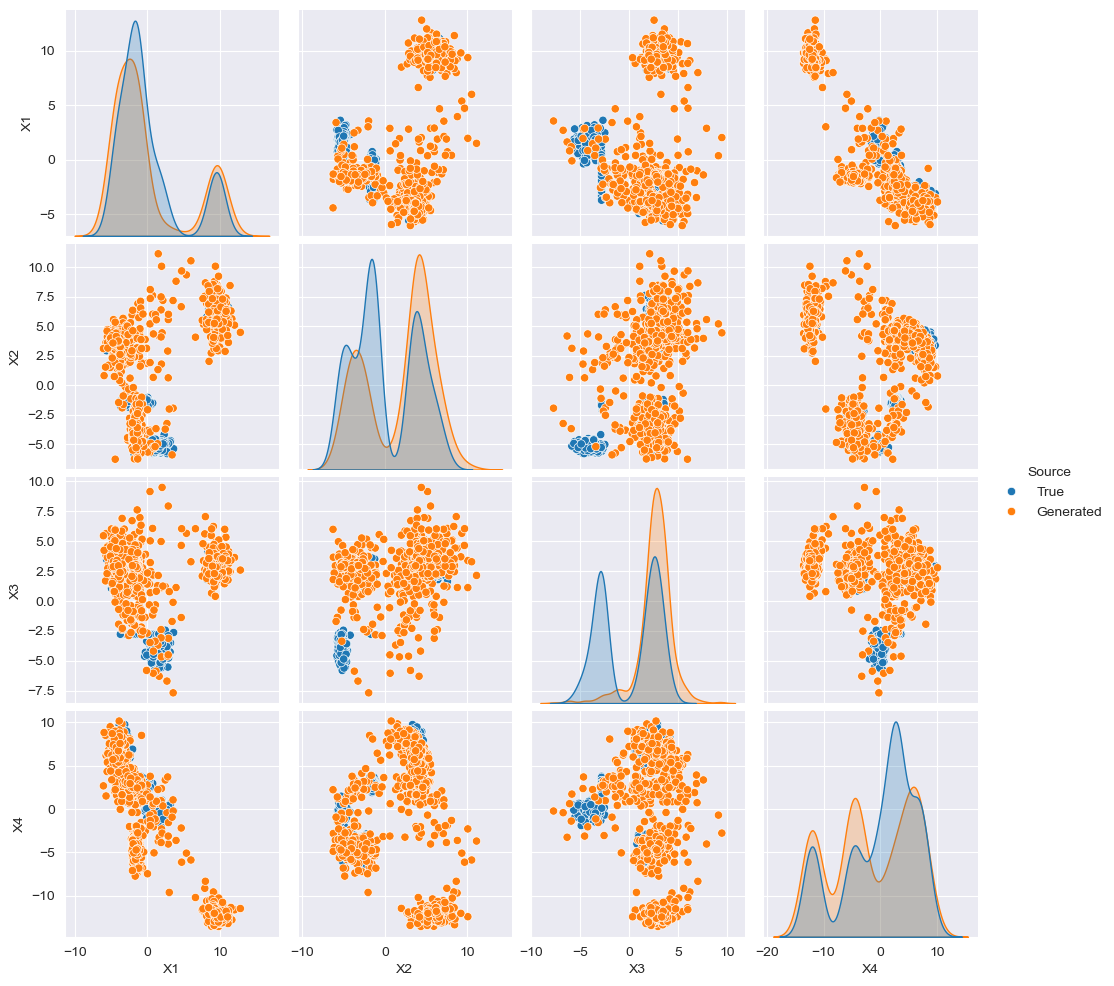

In [146]:
df = pd.DataFrame(xsampled, columns=['X1', 'X2', 'X3', 'X4'])
df_true = pd.DataFrame(torch_dataset, columns=['X1', 'X2', 'X3', 'X4'])

# Create pairwise scatter plot matrix
# sns.pairplot(df_true)
# Create pairwise scatter plot matrix
# Combine the two DataFrames with an additional column indicating the source
df_true['Source'] = 'True'
df['Source'] = 'Generated'
combined_df = pd.concat([df_true, df], ignore_index=True)

# Create pairwise scatter plot matrix with different colors for each source
plot_kws = {'alpha': 0.5}
sns.pairplot(combined_df, hue='Source', diag_kind='kde')
plt.savefig('pairplot_4d_10000.png')
plt.show()

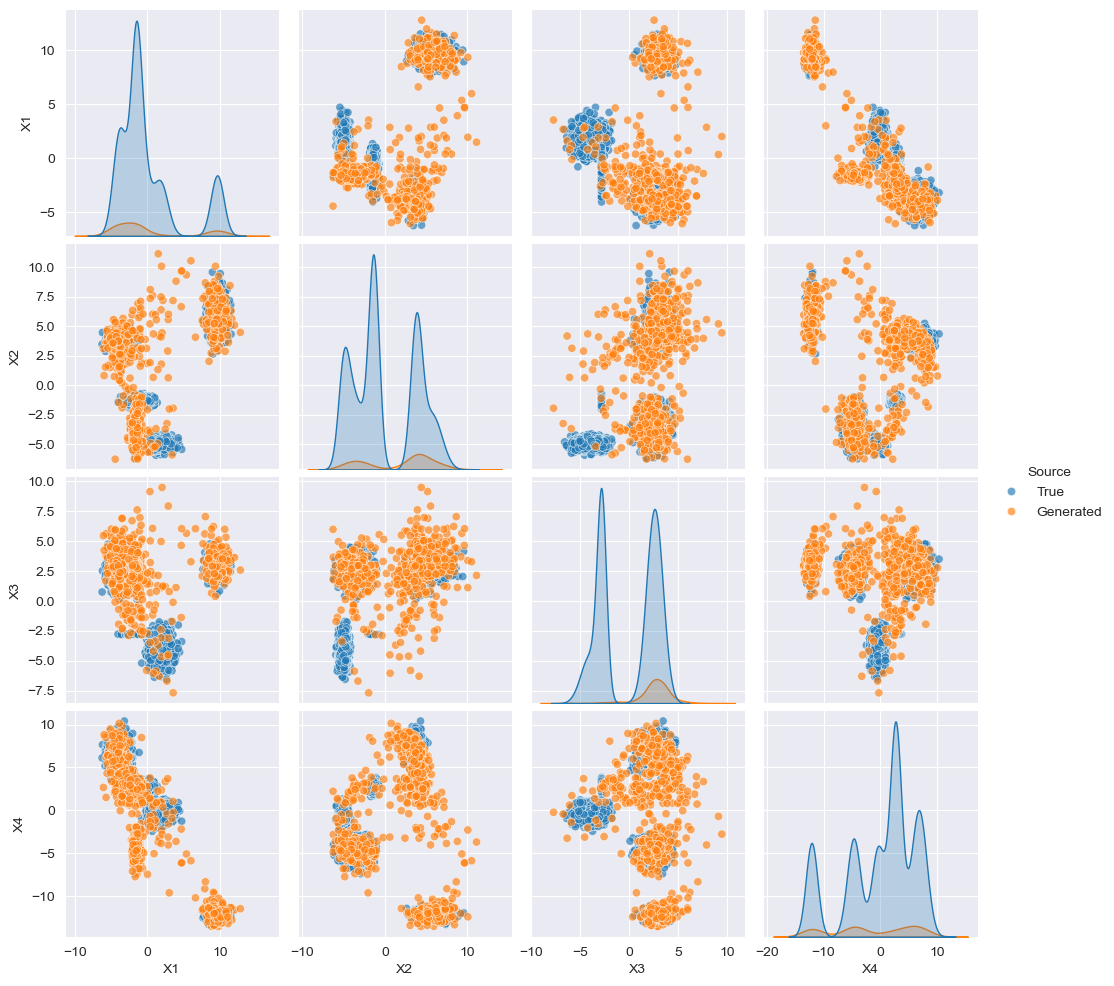

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `xsampled` and `torch_dataset` are defined earlier
df = pd.DataFrame(xsampled, columns=['X1', 'X2', 'X3', 'X4'])
df_true = pd.DataFrame(torch_dataset, columns=['X1', 'X2', 'X3', 'X4'])

# Combine the two DataFrames with an additional column indicating the source
df_true['Source'] = 'True'
df['Source'] = 'Generated'
combined_df = pd.concat([df_true, df], ignore_index=True)

# Define a custom plotting function to handle alpha for "Generated"
def custom_scatter(x, y, **kwargs):
    if kwargs.get('hue') == 'Generated':
        kwargs['alpha'] = 0.5
    plt.scatter(x, y, **kwargs)

# Create pairwise scatter plot matrix
g = sns.pairplot(
    combined_df,
    hue='Source',
    diag_kind='kde',
    plot_kws={'alpha': 0.65}  # Base alpha for all points
)

# Customize scatter plots to adjust alpha based on hue
for ax in g.axes.flatten():
    for line in ax.get_lines():
        if line.get_label() == 'Generated':
            line.set_alpha(0.2)
plt.savefig('pairplot_4D.png')
plt.show()


In [175]:
sum(xsampled.isnan())

tensor([9723, 9723, 9723, 9723])

tensor([[ 1.2114,  1.0243,  0.3248, -0.4371],
        [ 0.4057, -2.0627, -0.2223,  1.6357],
        [ 5.7253,  0.4232,  0.3809, -0.1257],
        ...,
        [ 5.9452, -1.3106, -0.0294,  0.3836],
        [ 1.5297,  1.2756,  1.8341,  0.7537],
        [ 1.1868, -0.7201,  0.1677, -1.2663]])


(-3.0, 3.0)

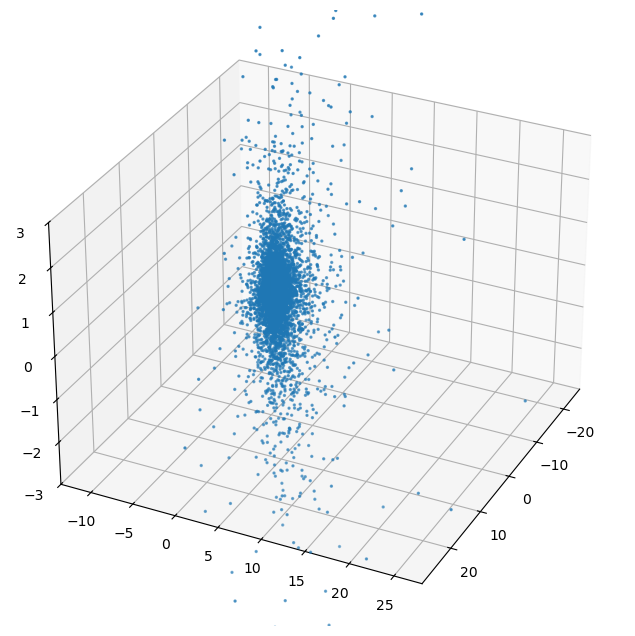

In [176]:
xsampled = prior.sample(n=num_samples)
print(xsampled)
xsampled[:, 1] = 0.5 * math.pi + torch.randn_like(xsampled[:, 1]) * 1.0
xsampled = to_cartesian(xsampled)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(xsampled[:, 0], xsampled[:, 1], xsampled[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.view_init(30, 26)
ax.set_zlim(-3, 3)

(array([4.000e+00, 1.100e+01, 2.300e+01, 2.250e+02, 8.921e+03, 7.630e+02,
        4.200e+01, 6.000e+00, 3.000e+00, 2.000e+00]),
 array([-22.6482029 , -17.79885101, -12.94949818,  -8.10014534,
         -3.25079346,   1.59855843,   6.44791222,  11.29726219,
         16.14661598,  20.99596977,  25.84531975]),
 <BarContainer object of 10 artists>)

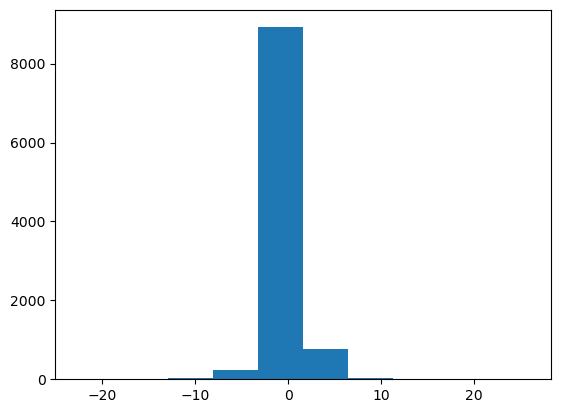

In [177]:
plt.hist(xsampled[:, 0])

(array([5.000e+00, 1.600e+01, 1.672e+03, 8.010e+03, 2.360e+02, 4.100e+01,
        1.300e+01, 3.000e+00, 1.000e+00, 3.000e+00]),
 array([-10.95814037,  -7.31701279,  -3.67588472,  -0.03475666,
          3.60637093,   7.24749851,  10.88862705,  14.52975368,
         18.17088318,  21.8120079 ,  25.45313644]),
 <BarContainer object of 10 artists>)

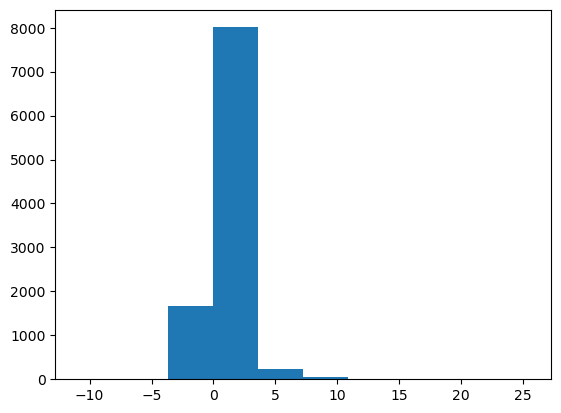

In [178]:
plt.hist(xsampled[:, 1])

(array([1.000e+00, 3.000e+00, 4.000e+00, 4.500e+01, 1.354e+03, 8.509e+03,
        6.500e+01, 1.200e+01, 4.000e+00, 3.000e+00]),
 array([-18.42848969, -14.8329916 , -11.23749352,  -7.64199638,
         -4.0464983 ,  -0.45100021,   3.14449692,   6.73999596,
         10.33549309,  13.93099213,  17.52649117]),
 <BarContainer object of 10 artists>)

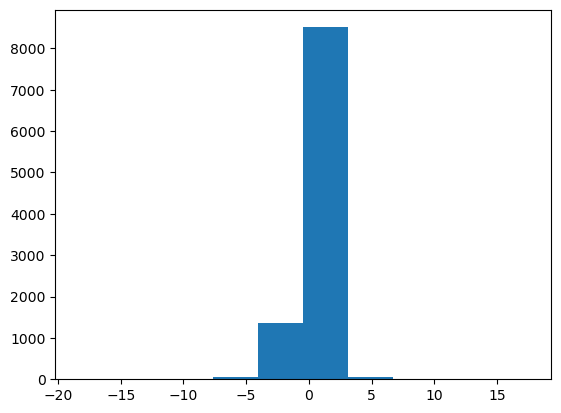

In [179]:
plt.hist(xsampled[:, 2])

In [180]:
xsampled

tensor([[ 1.2106e+00,  4.3723e-02,  1.3339e-02, -6.2332e-03],
        [ 6.2308e-02,  3.9105e-01,  5.7325e-03, -8.8199e-02],
        [ 4.8252e+00,  2.8608e+00,  1.1366e+00, -1.4364e-01],
        ...,
        [-1.4583e+00,  5.7611e+00, -1.5733e-01, -6.3503e-02],
        [ 6.3381e-01, -3.6237e-01,  9.8013e-01,  9.1996e-01],
        [-4.6355e-01,  1.0772e+00,  5.4690e-02, -1.7400e-01]])

In [181]:
x

tensor([[ 3.5161,  5.2346,  2.6746, -1.8926],
        [-2.3521, -8.5821, -2.1591,  0.3516],
        [ 4.6341,  5.0994,  2.7498, -1.8872],
        ...,
        [-2.2668, -8.4030, -2.2041,  0.9328],
        [ 4.0219,  5.6449,  2.5346, -1.6411],
        [-9.4876,  6.1080, -3.8240,  1.3809]])

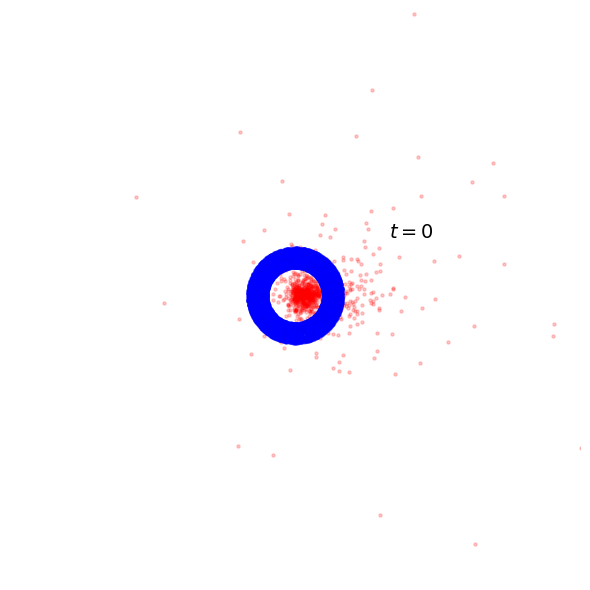

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: einsum(): subscript j has size 4 for operand 1 which does not broadcast with previously seen size 3

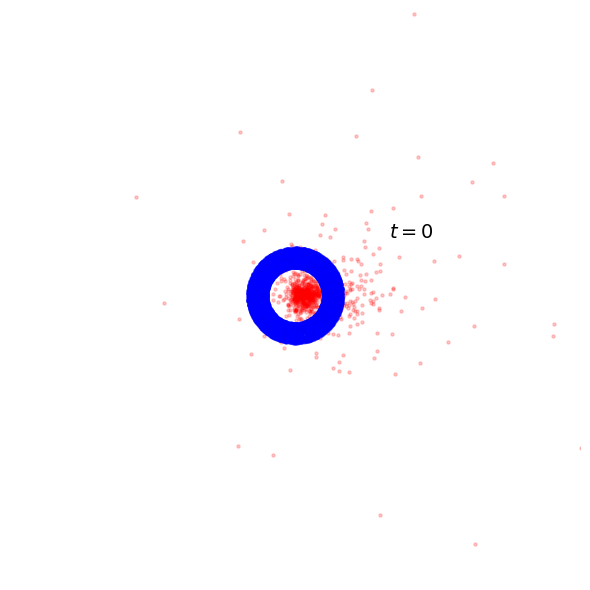

In [226]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi_dynamic = True

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

x_traj = []
xnumpy = x.detach().cpu()

fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
            
            r, theta, phi2, phi3 = to_hyperspherical(xsampled).chunk(4, dim=1)
            
            
            d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
            
            A_theta = torch.concat([
                -torch.sin(phi3),
                torch.cos(phi3),
                torch.zeros_like(phi3),
            ], dim=-1)
            
            A_theta = vector_to_skew_matrix(A_theta, Ax, Ay, Az)
            d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1))* torch.einsum('bij, bj -> bi', (A_theta, xsampled))
            
            d_phi =(0.5 * phi3 + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Az, xsampled))

            noise = torch.randn_like(score)
            nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
            n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
            n_phi = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Az, xsampled))
            
            #xsampled = (2.0 - torch.sqrt(1.0 - beta)) * xsampled # yang song sde
            #xsampled = xsampled + 0.5 * beta * xsampled
            
            if r_dynamic:
                xsampled = xsampled + beta * d_r
            if theta_dynamic:
                xsampled = xsampled + beta * d_theta
            if phi_dynamic:
                xsampled = xsampled + beta * d_phi
             
            if stochastic:
                # noise term + casimir invariant terms + divergence term
                if r_dynamic:
                    xsampled = xsampled + 1/1. * beta.sqrt() * nr + 0.5 * beta * xsampled  + 3.0 * beta * xsampled
                if theta_dynamic:
                    xsampled = xsampled + 1/1. * beta.sqrt() * n_theta - 0.5 * beta * xsampled 
                if phi_dynamic:
                    tmp = xsampled.clone()
                    tmp[:, -1] = 0.0
                    xsampled = xsampled + 1/1. * beta.sqrt() * n_phi - 0.5 * beta * tmp
                
                
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        clear_output(wait=True)
        display(fig)
        x_traj.append(xsampled)


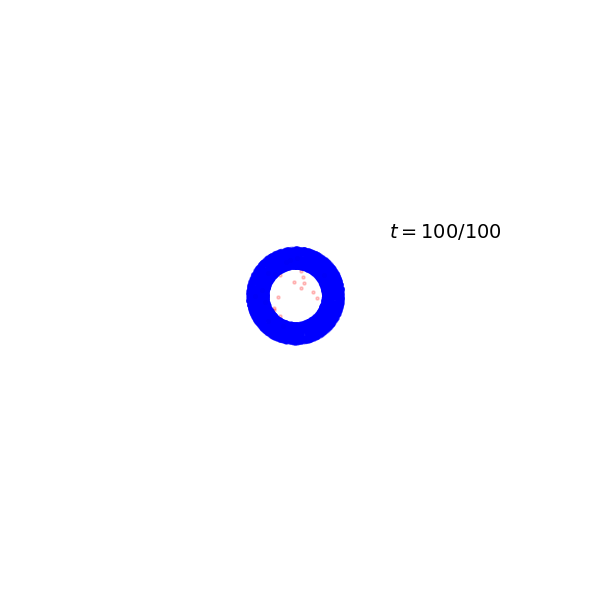

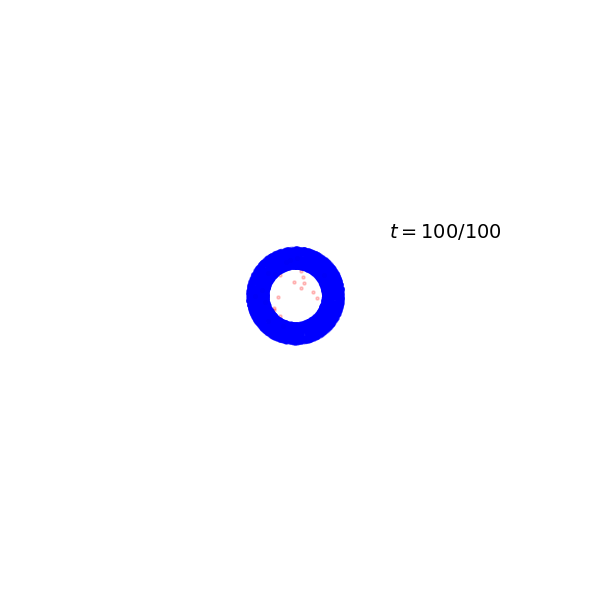

In [232]:
num_samples = 10000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi2_dynamic = True
phi3_dynamic = True

assert (sum((r_dynamic, theta_dynamic, phi2_dynamic, phi3_dynamic)) > 0)

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = x.detach().cpu()

fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):
        t_ = torch.tensor([t] * num_samples)

        beta = betas[t_].unsqueeze(-1)
        temb = (t_ / T).unsqueeze(-1)
        score = score_net(torch.concat([xsampled, temb], dim=-1))

        r, theta, phi2, phi3 = to_hyperspherical(xsampled).chunk(4, dim=1)

        # radius: drift and score
        d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
        A_phi3 = torch.concat([
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.ones_like(phi3),
        ], dim=-1)
        A_phi2 = torch.concat([
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.cos(phi3),
            torch.sin(phi3),
            torch.zeros_like(phi3),
        ], dim=-1)

        A_theta = torch.concat([
            torch.cos(phi2),
            torch.cos(phi3) * torch.sin(phi2),
            torch.sin(phi3) * torch.sin(phi2),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
            torch.zeros_like(phi3),
        ], dim=-1)

        A_phi2 = vector_to_skew_matrix4d(A_phi2, A12, A13, A14, A23, A24, A34)
        A_phi3 = vector_to_skew_matrix4d(A_phi3, A12, A13, A14, A23, A24, A34)
        A_theta = vector_to_skew_matrix4d(A_theta, A12, A13, A14, A23, A24, A34)
        # theta: drift and score
        d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        # phi: drift and score
        d_phi2 =(0.5 * phi2 + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Aphi2, xsampled))
        d_phi3 =(0.5 * phi3 + score[:, 3].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Aphi3, xsampled))

        noise = torch.randn_like(score)
        nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
        n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        n_phi2 = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Aphi2, xsampled))
        n_phi3 = noise[:, 3].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Aphi3, xsampled))

        if r_dynamic:
            x_update = xsampled + beta * d_r
        else:
            x_update = xsampled

        if theta_dynamic:
            x_update = x_update + beta * d_theta

        if phi2_dynamic:
            x_update = x_update + beta * d_phi2
        if phi3_dynamic:
            x_update = x_update + beta * d_phi3

        if stochastic:
            # noise term + casimir invariant terms + divergence term
            if r_dynamic:
                x_update = x_update + beta.sqrt() * nr - 1.5 * beta * xsampled # + 3.0 * beta * xsampled
            if theta_dynamic:
                tmp = xsampled.clone()
                z = (tmp[:, -1]).clone()
                tmp[:, -1] = 0.0
                xysq = tmp.pow(2).sum(-1).sqrt()
                coeff = z / xysq.clamp_min(1e-2)
                # coeff1 = theta.cos() / theta.sin()
                div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
                #div0_x = xsampled[:, 0] * z.pow(2) / xysq.pow(2)
                #div0_y = xsampled[:, 1] * z.pow(2) / xysq.pow(2)
                #div0_z = -z
                #div0 = torch.stack([div0_x, div0_y, div0_z], dim=-1)
                #print("coeff: ", coeff, coeff1)
                #print("Atheta: ", A_theta)
                #print("xsampled: ", xsampled)
                #print("div: ", div)
                #print("div1: ", div0)
                #print()
                #print("----------------" * 20)
                #print()
                A_theta_casimir = A_theta @ A_theta
                x_update = x_update + beta.sqrt() * n_theta  - 0.5 * beta  * torch.einsum('bij,bj->bi', A_phi2_casimir, xsampled) # + beta * div
            if phi2_dynamic:
                A_phi2_casimir = A_phi2 @ A_phi2

                x_update = x_update + beta.sqrt() * n_phi2  - 0.5 * beta * torch.einsum('bij,bj->bi', A_phi2_casimir, xsampled) + 0.0
                # print(x_update.norm(p=2, dim=-1))
            if phi3_dynamic:
                tmp = xsampled.clone()
                tmp[:, 0] = 0.0
                tmp[:, 1] = 0.0
                x_update = x_update + beta.sqrt() * n_phi3  - 0.5 * beta * tmp + 0.0
                # print(x_update.norm(p=2, dim=-1))


        xsampled = x_update
        x_traj.append(xsampled)

        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled[:, :3].cpu().detach().numpy())
        clear_output(wait=True)
        display(fig)
        x_traj.append(xsampled)





  0%|          | 0/1000 [00:00<?, ?epoch/s]

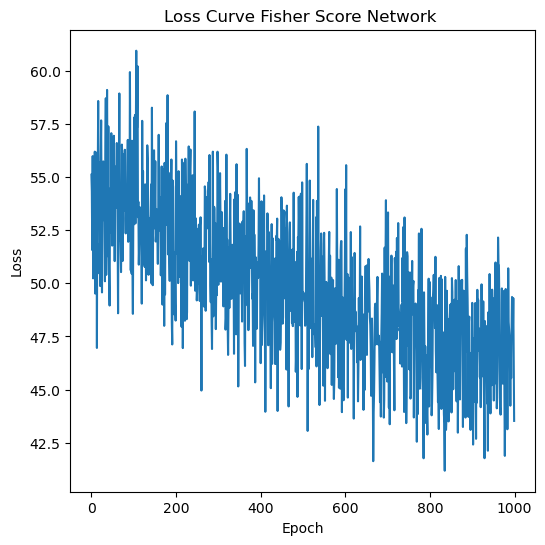

In [34]:
in_dim = 3
hidden_dim = 32
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            noise = torch.randn_like(xin)
            xt = signal.sqrt() * xin + std * noise
            target = noise
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Fisher Score Network ")
plt.show()

In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

xsampled = torch.randn(num_samples, in_dim) * 1.0

x_traj = []
xnumpy = x.detach().cpu()

fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
        
            # xsampled = (2.0 - (1.0 - beta).sqrt()) * xsampled + beta * score
            xsampled = xsampled + 0.5 * beta * xsampled
            xsampled = xsampled + beta * score
            #xsampled = 1 / (1.0 - beta).sqrt() * (xsampled + beta * score)
            
            if stochastic: 
                xsampled = xsampled + beta.sqrt() * torch.randn_like(xsampled)
            
            x_traj.append(xsampled)
            time_text.set_text(f'$t={i+1} / {T}$')
            scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
            clear_output(wait=True)
            display(fig)
        x_traj.append(xsampled)


In [ ]:
num_samples = 1000
chain = np.arange(T)
stochastic = True

xsampled = torch.randn(num_samples, in_dim) * 1.0

x_traj = []
xnumpy = x.detach().cpu()

m = 1
with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):        
        for j in range(m):
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
        
            # xsampled = (2.0 - (1.0 - beta).sqrt()) * xsampled + beta * score
            xsampled = xsampled + 0.5 * beta * xsampled
            xsampled = xsampled + beta * score
            #xsampled = 1 / (1.0 - beta).sqrt() * (xsampled + beta * score)
            
            if stochastic: 
                xsampled = xsampled + beta.sqrt() * torch.randn_like(xsampled)
        x_traj.append(xsampled)

     
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
if torus:
    ax.view_init(30, 26)
    ax.set_zlim(-3, 3)
plt.legend()

traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Fisher Score Network")
plt.show()


In [99]:


def generate_samples_from_mobius_strip(nsamples, width: float = 1.0, random_seed: int = 42):

    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Generate random values for u and v
    u = np.random.uniform(0, 2 * np.pi, nsamples)
    v = np.random.uniform(-width, width, nsamples)

    # Parametric equations for the Möbius strip
    x = (1 + (v / 2) * np.cos(u / 2)) * np.cos(u)
    y = (1 + (v / 2) * np.cos(u / 2)) * np.sin(u)
    z = (v / 2) * np.sin(u / 2)

    # Stack the coordinates
    mobius_strip_samples = np.stack([x, y, z], axis=1)

    return mobius_strip_samples

# Example usage
mobius_samples = generate_samples_from_mobius_strip(1000, width=1.0)
print(mobius_samples)


[[-0.61980853  0.62340082 -0.29072485]
 [ 0.91300338 -0.29212908  0.00646187]
 [-0.08485342 -0.74681385  0.27820037]
 ...
 [ 0.39694894  0.46075846 -0.17962158]
 [ 1.36784602 -0.44218592 -0.06896566]
 [-0.9083282   0.32054875 -0.2146868 ]]


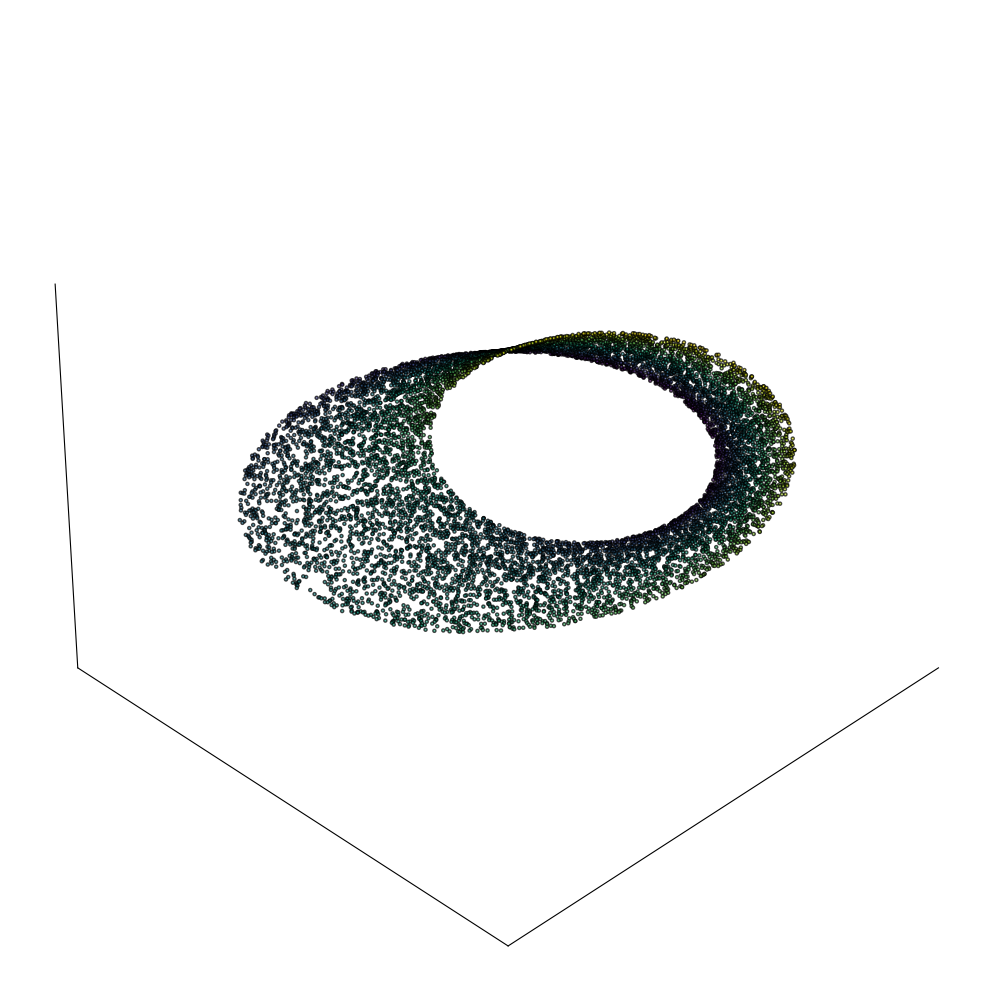

In [123]:
# Initialize plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Color map based on z values for depth effect
clean_array = xsampled_np[~np.isnan(xsampled_np).any(axis=1)]
dataset = generate_samples_from_mobius_strip(nsamples=10_000)
z_vals = dataset[:, 2]
colors = cm.viridis((z_vals - z_vals.min()) / (z_vals.max() - z_vals.min()))

# Scatter plot with color gradient and size adjustments
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=colors, s=5, alpha=0.7, edgecolor='k')

# Device for PyTorch operations (set to CPU for this example)
device = torch.device("cpu")

if torus:
    ax.view_init(35, 45)  
    ax.set_zlim(-3, 3)   

# Hide panes and axes
ax.xaxis.pane.fill = False  # Remove x-axis pane
ax.yaxis.pane.fill = False  # Remove y-axis pane
ax.zaxis.pane.fill = False  # Remove z-axis pane

ax.xaxis.pane.set_edgecolor((1, 1, 1, 0))  # Make the edge transparent
ax.yaxis.pane.set_edgecolor((1, 1, 1, 0))
ax.zaxis.pane.set_edgecolor((1, 1, 1, 0))
                    
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Finalize and show the plot
plt.tight_layout()
plt.savefig('mobius_distributions.png')
plt.show()


In [108]:
device = torch.device("cpu")
if isinstance(dataset, np.ndarray):
    x = torch.from_numpy(dataset).float()
else:
    x = dataset.clone()
bs = 128
ids = np.arange(len(dataset))
torch_dataset = x.clone().to(device)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

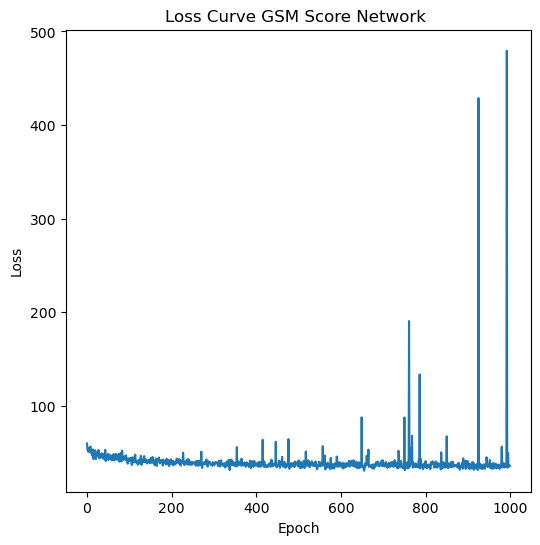

In [109]:
in_dim = 3
hidden_dim = 32
device = "cpu"
epochs = 1000
score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, hidden_dim),
                          nn.SiLU(), 
                          nn.Linear(hidden_dim, in_dim),
                          ).to(device)

normalize_tgt_by_std = True

optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
epoch_losses = []
with tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        epoch_loss = 0.0
        np.random.shuffle(ids)
        split = np.array_split(ids, math.ceil(len(ids) / bs))
        cnt = 0
        for i, idx in enumerate(split):
            t = torch.randint(low=1, high=T+1, size=(len(idx),))
            temb= (t / T).unsqueeze(-1)
            
            w = 1 + (1 / (temb + 1))
            w = torch.ones_like(w)
            
            signal = mean_coeff[t].unsqueeze(1)
            std = std_coeff[t].unsqueeze(1)
            
            xin = torch_dataset[idx]
            xt, target = forward_noising_vp(input=xin, m=signal, s=std, sqrt=True)
            
            optimizer.zero_grad()
            score = score_net(torch.concat([xt, temb], dim=1))
            target = - (target / std) if normalize_tgt_by_std else -target
            assert score.ndim == 2 and target.ndim == 2
            loss = (score - target).pow(2).sum(-1)
            loss = (w.squeeze(-1) * loss).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            cnt += 1
        epoch_loss /= cnt
        epoch_losses.append(epoch_loss)
        tepoch.set_postfix(loss=epoch_loss)
        
plt.figure(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve GSM Score Network ")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

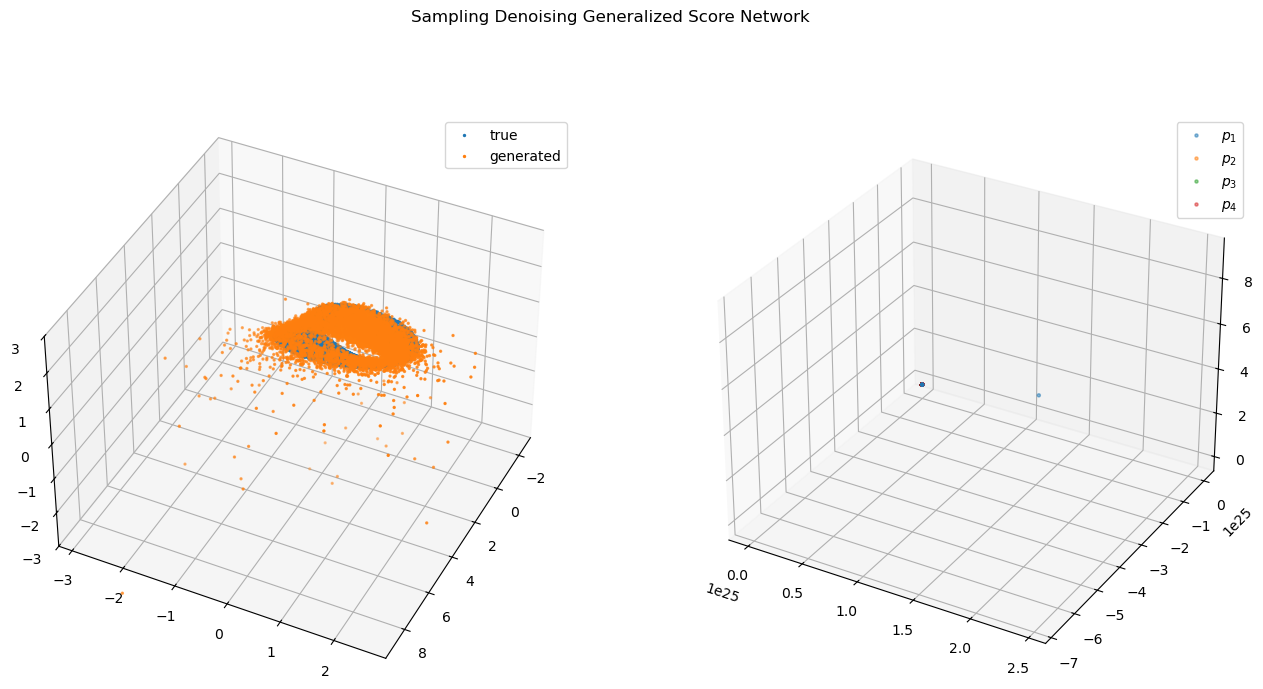

In [120]:
num_samples = 10000
chain = np.arange(T)
stochastic = True

r_dynamic = True
theta_dynamic = True
phi_dynamic = True

assert (sum((r_dynamic, theta_dynamic, phi_dynamic)) > 0)

xsampled = prior.sample(n=num_samples)
xsampled = to_cartesian(xsampled)
x_traj = []
xnumpy = xsampled.detach().cpu()

with torch.no_grad():
    for i, t in tqdm(enumerate(reversed(chain)), total=T):  
        t_ = torch.tensor([t] * num_samples)
        
        beta = betas[t_].unsqueeze(-1)
        temb = (t_ / T).unsqueeze(-1)
        score = score_net(torch.concat([xsampled, temb], dim=-1))
        
        r, theta, phi = to_spherical(xsampled).chunk(3, dim=1)
        
        # radius: drift and score
        d_r = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
        
        A_theta = torch.concat([
            -torch.sin(phi),
            torch.cos(phi),
            torch.zeros_like(phi),
        ], dim=-1)
            
        A_theta = vector_to_skew_matrix(A_theta, Ax, Ay, Az)
        # theta: drift and score
        d_theta = (0.5 * theta + score[:, 1].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
        # phi: drift and score
        d_phi =(0.5 * phi + score[:, 2].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (Az, xsampled))

        noise = torch.randn_like(score)
        nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
        n_theta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled)) 
        n_phi = noise[:, 2].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (Az, xsampled))
                
        if r_dynamic:
            x_update = xsampled + beta * d_r
        else:
            x_update = xsampled
            
        if theta_dynamic:
            x_update = x_update + beta * d_theta
                            
        if phi_dynamic:
            x_update = x_update + beta * d_phi
            
        if stochastic:
            # noise term + casimir invariant terms + divergence term
            if r_dynamic:
                x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled  + 0.5 * beta * xsampled
            if theta_dynamic:
                tmp = xsampled.clone()
                z = (tmp[:, -1]).clone()
                tmp[:, -1] = 0.0
                xysq = tmp.pow(2).sum(-1).sqrt()
                coeff = z / xysq.clamp_min(1e-2)
                # coeff1 = theta.cos() / theta.sin()
                div = coeff.unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A_theta, xsampled))
                #div0_x = xsampled[:, 0] * z.pow(2) / xysq.pow(2)
                #div0_y = xsampled[:, 1] * z.pow(2) / xysq.pow(2)
                #div0_z = -z
                #div0 = torch.stack([div0_x, div0_y, div0_z], dim=-1)
                #print("coeff: ", coeff, coeff1)
                #print("Atheta: ", A_theta)
                #print("xsampled: ", xsampled)
                #print("div: ", div)
                #print("div1: ", div0)
                #print()
                #print("----------------" * 20)
                #print()
                x_update = x_update + beta.sqrt() * n_theta  - 0.5 * beta * xsampled  # + beta * div
            if phi_dynamic:
                tmp = xsampled.clone()
                tmp[:, -1] = 0.0
                x_update = x_update + beta.sqrt() * n_phi  - 0.5 * beta * tmp + 0.0 
                # print(x_update.norm(p=2, dim=-1))

                
        xsampled = x_update                        
        x_traj.append(xsampled)
        
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], s=2, label="true")
xsampled_np = xsampled.detach().cpu().numpy()
ax.scatter(xsampled_np[:, 0], xsampled_np[:, 1], xsampled_np[:, 2], s=2, label="generated")
if torus:
    ax.view_init(40, 26)
    ax.set_zlim(-3, 3)
    
plt.legend()

traj_1 = torch.stack(x_traj)[:, -1, :].detach()
traj_2 = torch.stack(x_traj)[:, -2, :].detach()
traj_3 = torch.stack(x_traj)[:, -3, :].detach()
traj_4 = torch.stack(x_traj)[:, -4, :].detach()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(traj_1[:, 0], traj_1[:, 1], traj_1[:, 2], marker=".", alpha=0.5, label=r'$p_1$')
ax.scatter(traj_2[:, 0], traj_2[:, 1], traj_2[:, 2], marker=".", alpha=0.5, label=r'$p_2$')
ax.scatter(traj_3[:, 0], traj_3[:, 1], traj_3[:, 2], marker=".", alpha=0.5, label=r'$p_3$')
ax.scatter(traj_4[:, 0], traj_4[:, 1], traj_4[:, 2], marker=".", alpha=0.5, label=r'$p_4$')
plt.legend()
fig.suptitle("Sampling Denoising Generalized Score Network")
plt.show()

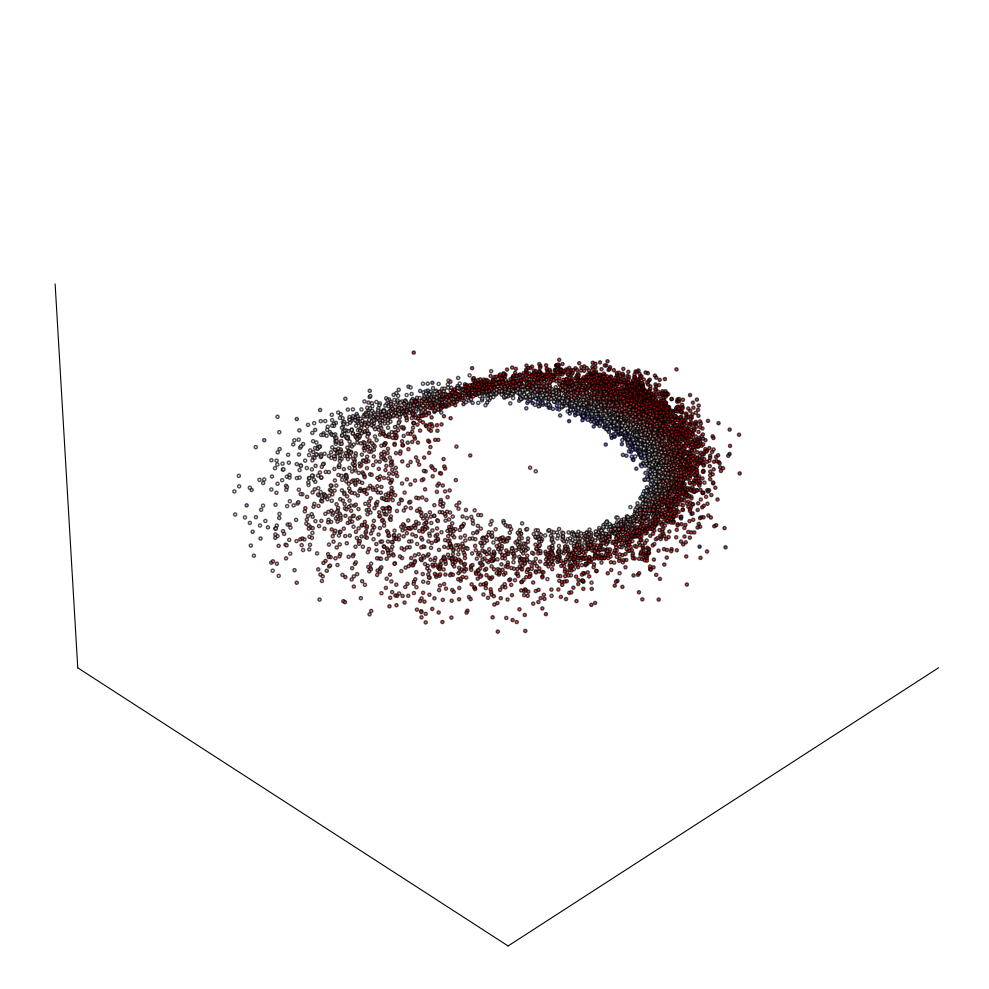

In [122]:
# Initialize plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')




clean_array = xsampled_np[~np.isnan(xsampled_np).any(axis=1)]
# dataset = generate_samples_from_mobius_strip(nsamples=10_000)
row_norms = np.linalg.norm(clean_array, axis=1)

filtered_array = clean_array[row_norms <= 2]

z_vals = filtered_array[:, 2]
colors = cm.seismic((z_vals - z_vals.min()) / (z_vals.max() - z_vals.min()))

# Scatter plot with color gradient and size adjustments
ax.scatter(filtered_array[:, 0], filtered_array[:, 1], filtered_array[:, 2], c=colors, s=5, alpha=0.7, edgecolor='k')

# Device for PyTorch operations (set to CPU for this example)
device = torch.device("cpu")

if torus:
    ax.view_init(35, 45)  
    ax.set_zlim(-3, 3)   

# Hide panes and axes
ax.xaxis.pane.fill = False  # Remove x-axis pane
ax.yaxis.pane.fill = False  # Remove y-axis pane
ax.zaxis.pane.fill = False  # Remove z-axis pane

ax.xaxis.pane.set_edgecolor((1, 1, 1, 0))  # Make the edge transparent
ax.yaxis.pane.set_edgecolor((1, 1, 1, 0))
ax.zaxis.pane.set_edgecolor((1, 1, 1, 0))
                    
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Finalize and show the plot
plt.tight_layout()
plt.savefig('mobius_distributions_gen.png')
plt.show()